In [30]:
# native python
import concurrent.futures
import datetime
import glob
import io
import logging
import os.path
import os.path
import urllib.parse


# numeric stuff
import numpy as np
import scipy.stats
import pandas # for tables

# converting things
import pathlib
import pydash # for functional stuff
import dateutil.parser # garbage date/times

# image processing
import skimage.io
import skimage.transform
from PIL import Image

# plotting
import matplotlib.pyplot as plt # plotting 
import matplotlib.dates # date axes
import seaborn


# web requests
import ssl
import requests # urls
import mako.template # html formatting

import IPython.display # notebook

%matplotlib inline

# replace default logging
#del logging.root.handlers[0]
#logging.basicConfig(level=logging.INFO)

In [4]:
# Create a sparql query to get all the oil paintings from the wikipedia
query = """

SELECT ?item ?itemLabel ?cid ?_image ?_inception ?_creator ?_creatorLabel WHERE {
  # select all paintings
  ?item wdt:P31 wd:Q3305213.
  # made with oil
  ?item wdt:P186 wd:Q296955.
  # written in english
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  # store the image
  OPTIONAL { ?item wdt:P18 ?_image. }
  # store the creation date
  OPTIONAL { ?item wdt:P571 ?_inception. }
  # store the creator
  OPTIONAL { ?item wdt:P170 ?_creator. }
}
"""

In [75]:
url = "https://query.wikidata.org/bigdata/namespace/wdq/sparql"
resp = requests.get(url, 
                    params=dict(query=query), 
                    headers={'Accept': 'application/json'})
data = resp.json()

In [76]:
# take a random sample
sample = False
if sample:
    data['results']['bindings'] = np.random.choice(data['results']['bindings'], replace=False, size=sample)
    len(data['results']['bindings'])

In [77]:
data

{'head': {'vars': ['item',
   'itemLabel',
   'cid',
   '_image',
   '_inception',
   '_creator',
   '_creatorLabel']},
 'results': {'bindings': [{'_creator': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q189117'},
    '_creatorLabel': {'type': 'literal',
     'value': 'Jan Matejko',
     'xml:lang': 'en'},
    '_image': {'type': 'uri',
     'value': 'http://commons.wikimedia.org/wiki/Special:FilePath/Prussian%20Homage.jpg'},
    '_inception': {'datatype': 'http://www.w3.org/2001/XMLSchema#dateTime',
     'type': 'literal',
     'value': '1879-01-01T00:00:00Z'},
    'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q317261'},
    'itemLabel': {'type': 'literal',
     'value': 'Prussian Homage',
     'xml:lang': 'en'}},
   {'_creator': {'type': 'uri',
     'value': 'http://www.wikidata.org/entity/Q42207'},
    '_creatorLabel': {'type': 'literal',
     'value': 'Caravaggio',
     'xml:lang': 'en'},
    '_image': {'type': 'uri',
     'value': 'http://common

In [19]:
# parse the dates
for row in data['results']['bindings']:
    # try and parse the date
    if '_inception' in row and row['_inception']['type'] == 'literal':
        try:
            date = row['_inception']['value']
            row['date'] = dateutil.parser.parse(date)
        except ValueError as e:
            logging.info("not parsed %s\n%s", date, row)
    # drop first part
    if pydash.has(row, 'item.value'):
        entity = row['item']['value'].split("/")[-1]
        row['entity'] = entity
            

In [20]:
rows = []
for row in data['results']['bindings']:
    creator = pydash.get(row, '_creatorLabel.value')
    name = pydash.get(row, 'itemLabel.value')

    datestr = pydash.get(row, '_inception.value')
    datetype = pydash.get(row, '_inception.type')
    img = pydash.get(row, '_image.value')
    entity = pydash.get(row, 'entity')
    if datestr and datetype == 'literal':
        try:
            date = dateutil.parser.parse(datestr)
        except:
            logging.exception("error %s\n%s", datestr, row)
    else:
        date = None
    rows.append(
        dict(
            creator=creator,
            name=name,
            date=date,
            img=img,
            entity=entity
        )
    )

In [58]:
df = pandas.DataFrame(data=rows)
# drop anonymous paintings
# df.ix[df.creator == 'anonymous'] = None
# drop missings and duplicates
df = df.dropna().drop_duplicates()
# calculate new index
df = df.reset_index()
len(df)

18594

In [59]:
df.set_index('entity').head()
df.to_json('paintings.json')

In [60]:
imgs = df.img
imgs.to_csv('urls.txt', index=False)

In [61]:
for entity, row in df.head().iterrows():
    resp = requests.head(row.img, allow_redirects=True)
    row['headers'] = resp.headers
row['headers']['Content-Length']

'994405'

In [66]:
df['chunk'] = df.index // 50
groups = df.groupby('chunk')
chunk_id, chunk = next(iter(groups))
chunk

,index,creator,date,entity,img,name,chunk
0,0,Leonardo da Vinci,1503-01-01 00:00:00+00:00,Q12418,http://commons.wikimedia.org/wiki/Special:File...,Mona Lisa,0
1,1,Gerard David,1490-01-01 00:00:00+00:00,Q23898,http://commons.wikimedia.org/wiki/Special:File...,Triptych of the Sedano family,0
2,2,Gerard David,1495-01-01 00:00:00+00:00,Q23898,http://commons.wikimedia.org/wiki/Special:File...,Triptych of the Sedano family,0
3,3,Francesco Guardi,1766-01-01 00:00:00+00:00,Q23908,http://commons.wikimedia.org/wiki/Special:File...,The Doge on the Bucintoro near the Riva di San...,0
4,4,Francesco Guardi,1766-01-01 00:00:00+00:00,Q23908,http://commons.wikimedia.org/wiki/Special:File...,The Doge on the Bucintoro near the Riva di San...,0
5,5,Francesco Guardi,1775-01-01 00:00:00+00:00,Q23908,http://commons.wikimedia.org/wiki/Special:File...,The Doge on the Bucintoro near the Riva di San...,0
6,6,Francesco Guardi,1775-01-01 00:00:00+00:00,Q23908,http://commons.wikimedia.org/wiki/Special:File...,The Doge on the Bucintoro near the Riva di San...,0
7,7,Eugène Delacroix,1830-01-01 00:00:00+00:00,Q23912,http://commons.wikimedia.org/wiki/Special:File...,A Young Tiger Playing with its Mother,0
8,8,Titian,1515-01-01 00:00:00+00:00,Q23922,http://commons.wikimedia.org/wiki/Special:File...,Woman with a Mirror,0
9,9,Jean Auguste Dominique Ingres,1806-01-01 00:00:00+00:00,Q24011,http://commons.wikimedia.org/wiki/Special:File...,Mademoiselle Caroline Rivière,0


In [67]:

# get a token from: /w/api.php?action=query&format=json&meta=tokens&type=csrf%7Clogin
def url2name(url):
    return urllib.parse.unquote(url.split(':')[-1].replace('FilePath/', 'File:'))


names = "|".join(chunk.img.apply(url2name))
url = 'https://commons.wikimedia.org/w/api.php'
params = {
    "action": "query",
    "titles": names,
    "prop": "imageinfo",
    "iiprop": "timestamp|thumbmime|bitdepth|dimensions|sha1|url|mediatype|metadata|extmetadata",
    "format": "json"

}
headers = {'Accept': 'application/json'}
data = requests.get(url, params=params, headers=headers, allow_redirects=True).json() #.content.decode('utf-8')

In [73]:
list(data['query']['pages'].values())

[{'imageinfo': [{'bitdepth': 8,
    'descriptionshorturl': 'https://commons.wikimedia.org/w/index.php?curid=30215816',
    'descriptionurl': 'https://commons.wikimedia.org/wiki/File:Tiziano,_madonna_del_coniglio,_1525-30_ca._02.JPG',
    'extmetadata': {'Artist': {'source': 'commons-desc-page',
      'value': '<span class="fn value">\n<a href="//commons.wikimedia.org/wiki/User:Sailko" title="User:Sailko">Sailko</a></span>'},
     'Assessments': {'hidden': '',
      'source': 'commons-categories',
      'value': ''},
     'AttributionRequired': {'hidden': '',
      'source': 'commons-desc-page',
      'value': 'true'},
     'Categories': {'hidden': '',
      'source': 'commons-categories',
      'value': 'Artworks with Wikidata item|Madonna of the Rabbit by Titian|Photographs by User:Sailko|Self-published work|Uploaded with UploadWizard'},
     'CommonsMetadataExtension': {'hidden': '',
      'source': 'extension',
      'value': 1.2},
     'Copyrighted': {'hidden': '',
      'source': 

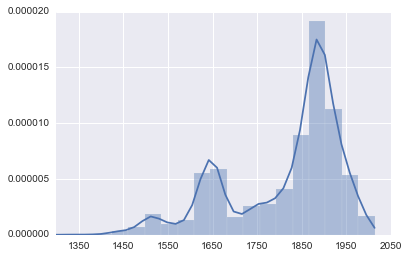

In [12]:
# analyze all data
dates = []
for row in data['results']['bindings']:
    if 'date' in row:
        dates.append(
            matplotlib.dates.date2num(row['date'])
        )
        
ax = seaborn.distplot(dates)
start_date = matplotlib.dates.date2num(datetime.datetime(1300, 1, 1))
end_date = matplotlib.dates.date2num(datetime.datetime(2050, 1, 1))
ax.set_xlim(start_date, end_date)
ax.xaxis_date()

In [18]:
table = pandas.crosstab(df.creator, columns=['creator'])
table.sort_values(by="creator", ascending=False).head()

col_0,creator
creator,
Rembrandt,614
Camille Pissarro,406
Vincent van Gogh,331
Albert Bierstadt,309
Jacob van Ruisdael,301


In [25]:
def save_img(row):
    # get url
    url = row['img']
    # lookup id
    entity = row['entity'] 
    filename = "paintings/%s.jpg" % (entity, )
    if os.path.exists(filename):
        print('.', end='', flush=True)
        return
    # download
    print(url)
    try:
        resp = requests.get(url, timeout=5)
    except requests.exceptions.Timeout as e:
        print('t', end='', flush=True)
        return
    print(resp, entity)
    if not resp.status_code == 200:
        print('x', end='', flush=True)
        return
    # get the bytes
    content = io.BytesIO(resp.content)
    
    # open as image
    try:
        im = Image.open(content)
    except:
        print('e', end='', flush=True)
        return
    # scale down
    N = 256
    im.thumbnail((N, N))
    # save
    im.save(filename)
    print('V', end='', flush=True)
row = df.iloc[0].to_dict()
save_img(row)

http://commons.wikimedia.org/wiki/Special:FilePath/Mona%20Lisa%2C%20by%20Leonardo%20da%20Vinci%2C%20from%20C2RMF%20retouched.jpg
<Response [200]> Q12418
V

In [ ]:

# work
rows = [row.to_dict() for (i, row) in df.iterrows()]
# execute it

for row in rows:
    try:
        save_img(row)
    except:
        logging.exception("saving failed")
#with concurrent.futures.ProcessPoolExecutor(max_workers=4) as executor:
#    executor.map(save_img, rows)